# Inicialização

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/Github/PAC
#%cd ..

/content/drive/MyDrive/Github/PAC


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from src.config import Paths
from src.data import load_all
from src.measure import scale_from_mask
from src import visualize as vs

In [3]:
images, labels, areas = load_all(area=True, grayscale=True, as_tensor=False, norm=True)
num_samples = len(images)
scale_true = scale_from_mask(areas, labels)
images.shape, labels.shape, scale_true.shape

((63, 256, 256), (63, 256, 256), (63,))

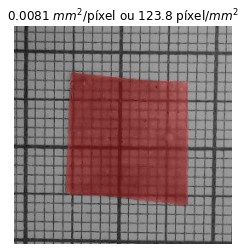

In [193]:
i = np.random.randint(num_samples)
img = images[i]
I, G, St = images[i], labels[i], scale_true[i]

vs.plot_label(I, G)
plt.title(r'{:.4f} $mm^2$/píxel ou {:.1f} píxel/$mm^2$'.format(St, 1/St))
plt.show()

# Detecção da escala

In [54]:
from scipy.ndimage import gaussian_filter
from scipy.stats import mode
from src.measure import FFT, Cxx, PSD

freqs = np.fft.fftfreq(I.shape[1])
pos = freqs > 0
freqs.shape

(256,)

## Metodologia

In [55]:
def plot_on(axs, xy, *args, **kwargs):
    for ax, (x, y) in zip(axs, xy):
        ax.plot(x, y, *args, **kwargs)

def plot_step(inpt, func, titles=None):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))

    pattern = np.random.randint(0, inpt.shape[0], 20)
    plot_on(axs.flat, [
        [range(inpt.shape[1]), inpt[pattern].T],
        [freqs[pos], np.apply_along_axis(lambda x: func(x)[pos], 1, inpt[pattern]).T]
    ], 'C0-', alpha=0.2)

    axs[1].vlines(np.sqrt(St), *axs[1].get_ylim(), color='r', lw=3, ls='dashed', label=r'$\xi_{true}$')
    axs[1].legend(fontsize=14)

    axs[1].set_xlabel(r'$\xi$ [p$^{-1}$]')
    if titles is not None: 
        for title, ax in zip(titles, axs):
            ax.set_title(title, fontsize=14)
    fig.tight_layout()
    plt.show()

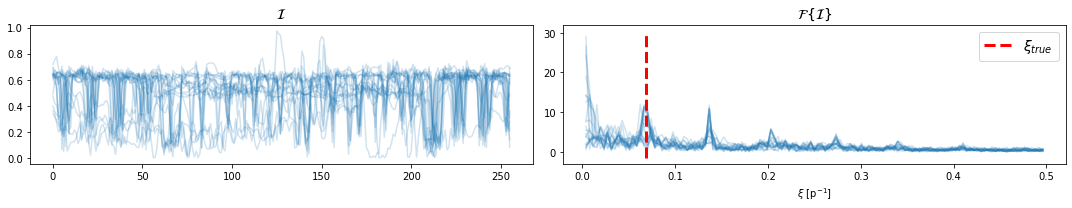

In [56]:
plot_step(I, FFT, titles=(r'$\mathcal{I}$', r'$\mathcal{F}\{\mathcal{I}\}$'))

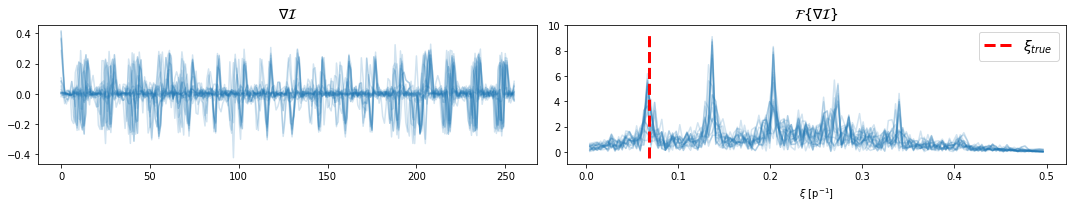

In [57]:
Ix = np.gradient(I)[0].T
plot_step(Ix, FFT, titles=(r'$\nabla\mathcal{I}$', r'$\mathcal{F}\{\nabla\mathcal{I}\}$'))

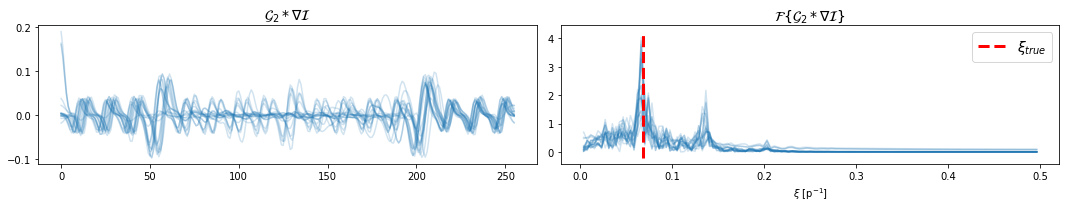

In [58]:
Ix_gauss = gaussian_filter(Ix, 2)
plot_step(Ix_gauss, FFT, titles=(r'$\mathcal{G}_2*\nabla\mathcal{I}$', r'$\mathcal{F}\{\mathcal{G}_2*\nabla\mathcal{I}\}$'))

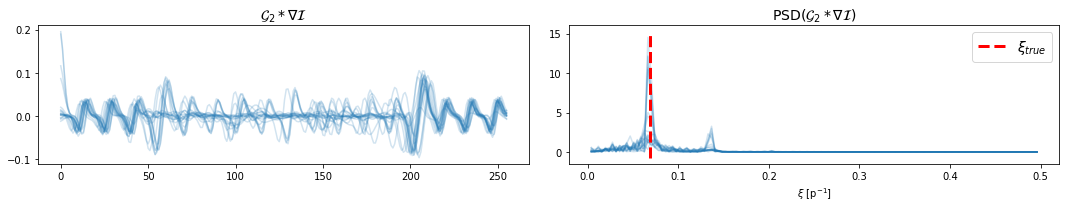

In [59]:
plot_step(Ix_gauss, PSD, titles=(r'$\mathcal{G}_2*\nabla\mathcal{I}$', r'PSD$(\mathcal{G}_2*\nabla\mathcal{I})$'))

<ipython-input-60-b59c4d63c332>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  plt.vlines(mode(D).mode[0], 0, h.max(), color='c', lw=3, ls='dashed', label=r'Valor estimado')


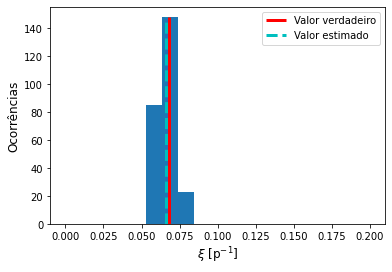

In [60]:
D = np.apply_along_axis(lambda y: np.abs(freqs[np.argmax(FFT(y))]), 1, Ix_gauss)
h, _, _ = plt.hist(D, bins=np.linspace(0, 0.2, 20))
plt.vlines(np.sqrt(St), 0, h.max(), color='r', lw=3, label=r'Valor verdadeiro')
plt.vlines(mode(D).mode[0], 0, h.max(), color='c', lw=3, ls='dashed', label=r'Valor estimado')
plt.legend()
plt.xlabel(r'$\xi$ [p$^{-1}$]', fontsize=12)
plt.ylabel('Ocorrências', fontsize=12)
plt.show()

## Implementação e testes

In [ ]:
def find_scale_tests(img, sigma=2, method='mean'):
    Iy, Ix = np.gradient(img)
    fs, stds = [], []
    for dI in (Ix, Iy.T):
        freqs = np.fft.fftfreq(dI.shape[1], 1)
        pos = freqs > 0
        dI_gauss = nd.gaussian_filter(dI, sigma)
        D = np.apply_along_axis(lambda y: freqs[pos][np.argmax(PSD(y)[pos])], 1, dI_gauss)

        if method == 'mean':
            fs.append(D.mean())
            stds.append(D.std())
        elif method == 'mode':
            fs.append(stats.mode(D).mode[0])
            stds.append(0.5/dI.shape[1])

    (fx, fy), (dx, dy) = fs, stds
    return fx*fy, np.sqrt((dx*fy)**2 + (dy*fx)**2)

def perc_error(y_true, y_pred):
    return np.abs(y_true - y_pred)/y_true * 100

In [ ]:
gaussian_scale = np.arange(0, 10, 0.25)
out = {}
for method in ('mean', 'mode'):
    try: 
        %time out[method] = np.stack([[find_scale_tests(image, sigma=sigma, method=method) for image in images] for sigma in gaussian_scale])
    except Exception as error: print(error)

CPU times: user 1min 21s, sys: 198 ms, total: 1min 21s
Wall time: 1min 23s
CPU times: user 1min 22s, sys: 210 ms, total: 1min 22s
Wall time: 1min 23s


1.75 4.949629986761819
2.0 2.2185189774468745


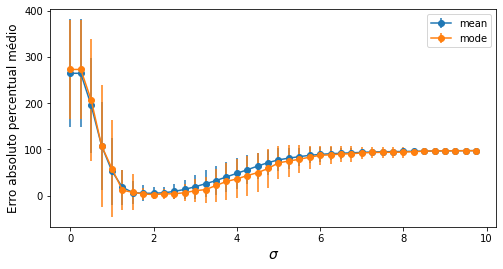

In [ ]:
plt.figure(figsize=(8, 4))

best_config = None
min_error_global = np.inf
for method, pred in out.items():
    error = perc_error(scale_true, pred[:, :, 0])
    plt.errorbar(gaussian_scale, error.mean(axis=1), error.std(axis=1), fmt='-o', label=method)

    min_error_loc = np.argmin(error.mean(axis=1))
    min_error = error[min_error_loc].mean()
    if min_error < min_error_global:
        min_error_global = min_error
        best_config = {'sigma':gaussian_scale[min_error_loc], 'method':method}
    print(gaussian_scale[min_error_loc], min_error)

plt.legend()
plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel('Erro absoluto percentual médio', fontsize=12)
plt.show()

CPU times: user 2.53 s, sys: 10.6 ms, total: 2.54 s
Wall time: 3.33 s


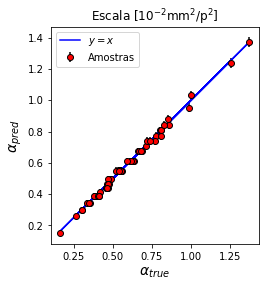

In [ ]:
%time scale_pred = np.stack([find_scale_tests(image, **best_config) for image in images])
fig, ax = plt.subplots()
plt.errorbar(scale_true*1e2, scale_pred[:, 0]*1e2, scale_pred[:, 1]*1e2, fmt='o', markeredgecolor='k', markerfacecolor='r', color='k', label='Amostras')
plt.plot(scale_true*1e2, scale_true*1e2, 'b-', label='$y=x$')
plt.legend()
plt.title(r'Escala [10$^{-2}$mm$^2$/p$^2$]')
plt.xlabel(r'$\alpha_{true}$', fontsize=14)
plt.ylabel(r'$\alpha_{pred}$', fontsize=14)
ax.set_aspect('equal')
plt.show()

In [ ]:
rel_error = np.abs(scale_true - scale_pred[:, 0])/scale_true*100
stats.describe(rel_error)

DescribeResult(nobs=63, minmax=(0.08075609679066423, 5.804372033803283), mean=2.2185189774468745, variance=2.641252966044786, skewness=0.6594472793187326, kurtosis=-0.5979779431517991)

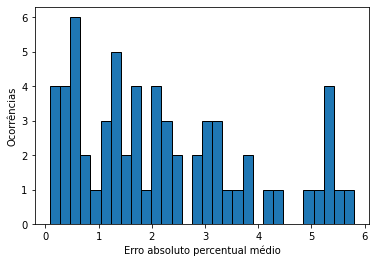

In [ ]:
plt.hist(rel_error, bins=30, edgecolor='k')
plt.ylabel('Ocorrências')
plt.xlabel('Erro absoluto percentual médio')
plt.show()

In [ ]:
i = np.random.randint(num_samples)
alpha, d_alpha = scale_pred[i]
parea = labels[i].sum()

print('Escala detectada:', '(%s +- %s) píxels/mm^2'%(1/alpha, d_alpha/alpha**2))
print('Area verdadeira:', areas[i])
print('Area estimada:', '(%s +- %s) mm^2'%(parea*alpha, parea*d_alpha))

Escala detectada: (123.88657844990549 +- 3.8087408573881465) píxels/mm^2
Area verdadeira: 138.338
Area estimada: (139.353271484375 +- 4.284245358570935) mm^2


## Modelo tensorflow

In [ ]:
from src.measure import measurer, find_scale
from src.metrics import gauge

In [ ]:
scale_model = measurer(find_scale, (256, 256), tf.float64, 'scale_measurer', sigma=2)
scale_model.compile(loss=gauge(tf.keras.metrics.mape), metrics=[gauge(tf.keras.metrics.mae), gauge(tf.keras.metrics.mse)])
scale_model.summary()

Model: "scale_measurer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256)]        0         
                                                                 
 lambda (Lambda)             None                      0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
scale_model.evaluate(tf.stack(images), tf.stack(scale_true))

2/2 [==============================] - 3s 764ms/step - loss: 2.2185 - mean_absolute_error: 1.2142e-04 - mean_squared_error: 2.3266e-08


[2.2185189723968506, 0.00012142455670982599, 2.3265737780775453e-08]

In [ ]:
scale_model.save('models/scale_measurer.h5')
!ls models/*.h5

models/scale_measurer.h5  models/slope_measurer.h5


# Detecção da inclinação

In [ ]:
from skimage.transform import rotate

## Metodologia

In [ ]:
from src.measure import FFT2
from scipy.stats import circmean, circstd

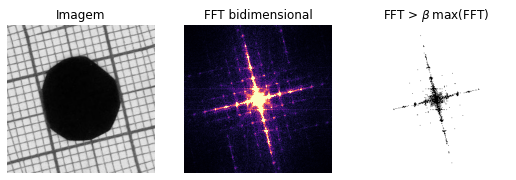

In [ ]:
angle = 15
beta = 3e-3

fig = plt.figure(figsize=(9, 3))

I = rotate(img, angle, mode='reflect')
fft2d = FFT2(I)
L = fft2d > fft2d.max()*beta

fig.add_subplot(131)
vs.plot_image(I, cmap='gray')
plt.title('Imagem')

fig.add_subplot(132)
vs.plot_image(fft2d, cmap='magma', vmax=fft2d.max()*beta)
plt.title('FFT bidimensional')

fig.add_subplot(133)
vs.plot_image(L, cmap='binary')
plt.title(r'FFT > $\beta\,\max$(FFT)')

plt.show()

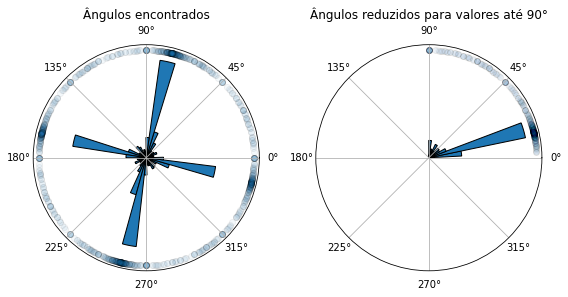

In [ ]:
X = np.arange(-I.shape[1]//2, I.shape[1]//2)
Y = np.arange(-I.shape[0]//2, I.shape[0]//2)
X, Y = np.meshgrid(X, Y)
H = np.arctan2(Y[L], X[L])
H_90 = np.pi/2 - H%(np.pi/2)

angle_pred = stats.circmean(H_90, high=np.pi/2)

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122, projection='polar')

N = 40
h, _, _ = ax1.hist(H, bins=N, width=2*np.pi/N, edgecolor='k', density=True)
ax1.scatter(H, np.full(H.shape, h.max() + h.ptp()*0.1), alpha=0.05, edgecolor='k')

N = 10
bins = np.linspace(0, np.pi/2, N+1)
h, _, _ = ax2.hist(H_90, bins=N, width=np.pi/2 * 1/N, edgecolor='k', density=True)
h_max = h.max() + h.ptp()*0.1
ax2.scatter(H_90, np.full(H.shape, h_max), alpha=0.01, edgecolor='k')

ax1.set_yticks([])
ax1.set_title('Ângulos encontrados', pad=15)
ax2.set_yticks([])
ax2.set_title('Ângulos reduzidos para valores até 90°', pad=15)
fig.tight_layout()
plt.show()

## Implementação e testes

In [ ]:
from src.measure import find_slope

In [ ]:
angle_true = np.arange(1, 91)
%time angle_pred = np.stack([[find_slope(rotate(img, angle, mode='reflect'), 3e-3) for angle in angle_true] for img in images])
angle_pred.shape

CPU times: user 46.7 s, sys: 74.3 ms, total: 46.7 s
Wall time: 47.2 s


(63, 90, 2)

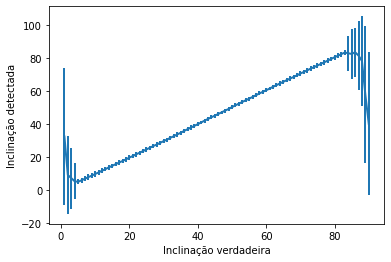

In [ ]:
plt.errorbar(angle_true, angle_pred[..., 0].mean(axis=0), angle_pred[..., 0].std(axis=0), lw=2)
plt.xlabel('Inclinação verdadeira')
plt.ylabel('Inclinação detectada')
plt.show()

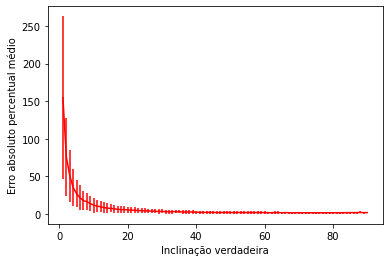

(63, 90)

In [ ]:
error_abs = np.abs(angle_true[np.newaxis] - angle_pred[..., 0])
error = np.where(error_abs > 45, np.abs(90 - error_abs), error_abs)/angle_true[np.newaxis] * 100

plt.errorbar(angle_true, error.mean(axis=0), error.std(axis=0), color='r')
plt.xlabel('Inclinação verdadeira')
plt.ylabel('Erro absoluto percentual médio')
plt.show()
error.shape

7.198025931833806

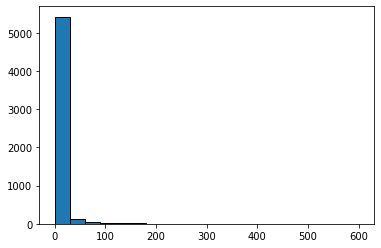

In [ ]:
plt.hist(error.flat, bins=20, edgecolor='k')
error.mean()

In [ ]:
!pip install celluloid

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.animation import PillowWriter
from celluloid import Camera

In [ ]:
fig = plt.figure(figsize=(16, 4))
#gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143, projection='polar')
ax4 = fig.add_subplot(144, projection='polar')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

def update(angle):
    I = rotate(img, angle, mode='reflect')
    fft2d = FFT2(I)
    L = fft2d > fft2d.max()*2.5e-3
    X = np.arange(-img.shape[1]//2, img.shape[1]//2)
    Y = np.arange(-img.shape[0]//2, img.shape[0]//2)
    X, Y = np.meshgrid(X, Y)
    H = np.arctan2(Y[L], X[L])
    H_90 = (np.pi/2) - H%(np.pi/2)

    ax1.imshow(I, cmap='gray')
    ax2.imshow(fft2d, cmap='magma', vmax=fft2d.max()*2.5e-3)
    ax3.hist(H, bins=40, edgecolor='k', density=True, color='C0')
    ax4.hist(H_90, bins=10, edgecolor='k', density=True, color='C0')

update(0)
fig.tight_layout()

camera = Camera(fig)
for angle in range(1, 91):
    update(angle)
    camera.snap()

animation = camera.animate()
animation.save('reports/figures/slope_detection.gif', writer=PillowWriter(fps=10))
plt.close()

![](../reports/figures/slope_detection.gif)

## Modelo tensorflow

In [ ]:
from src.measure import measurer
from src.metrics import gauge, angular_distance, angular_mape

In [ ]:
scale_model = measurer(find_slope, (256, 256), tf.float64, 'slope_measurer', beta=3e-3)
scale_model.compile(loss=gauge(angular_mape), metrics=[gauge(angular_distance)])
scale_model.summary()

Model: "slope_measurer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256)]        0         
                                                                 
 lambda_1 (Lambda)           None                      0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
angle_true = tf.range(10, 90, 5, dtype=tf.float64)
rotated_images = [[rotate(image, angle, mode='reflect') for angle in angle_true] for image in images]
np.shape(rotated_images), angle_true.shape

((63, 16, 256, 256), TensorShape([16]))

In [ ]:
scale_model.evaluate(tf.concat(rotated_images, axis=0), tf.tile(angle_true, [len(images)]))

32/32 [==============================] - 6s 159ms/step - loss: 3.2308 - angular_distance: 1.0533


[3.2308430671691895, 1.0533026456832886]

In [ ]:
scale_model.save('models/slope_measurer.h5')
!ls models/*.h5

models/scale_measurer.h5  models/slope_measurer.h5


# Limitações

## Rotação

In [ ]:
%%time
quad = np.arange(1, 91)
out = np.stack([[find_scale(rotate(image, angle, mode='reflect'), sigma=2) for angle in quad] for image in images])
out.shape

CPU times: user 3min, sys: 448 ms, total: 3min 1s
Wall time: 3min 7s


(63, 90, 2)

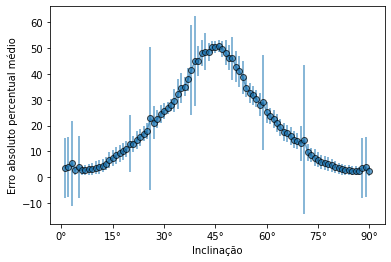

In [ ]:
abs_error = np.abs(scale_true[:, np.newaxis] - out[..., 0])
rel_error = abs_error/scale_true[:, np.newaxis] * 100
plt.errorbar(quad, rel_error.mean(axis=0), rel_error.std(axis=0), fmt='-o', alpha=0.7, markeredgecolor='k')
plt.xlabel('Inclinação')
plt.ylabel('Erro absoluto percentual médio')

loc = np.arange(0, 91, 15)
plt.xticks(loc, [f'{int(value)}°' for value in loc])

plt.show()

## Quantidade de papel milimetrado

É de se esperar que a quantidade de papel milimetrado na imagem altere a precisão do algoritmo de detecção da escala. Considere $A_{total}$ a área (em píxels) total da imagem e $A_k$ uma quantidade de área que será recortada das laterais da imagem.

Definindo 
$$
A_k = 2k(h + w) - 4k^2,
$$ 
sendo $h$ e $w$ as dimensões da imagem, temos que $k \in \left\{\mathbb{Z}|1 \le k < \frac{1}{2} \min(h, w)\right\}$, ou em outras palavras, $k$ consiste na largura que será recortada das laterais da imagem.

Seja $a_{papel}$ a quantidade relativa de papel milimetrado na imagem:
$$
a_{papel} = 1 - \frac{A_{pellet}}{A_{total} - A_k},
$$
onde $A_{pellet}$ consiste na área da região que pertence à pastílha, com a imagem já recortada.

In [ ]:
h, w = images.shape[1:]
k = np.arange(1, int(min(h, w)/2) - 1)
A_total = h*w
A_k = 2*k*(h + w) - 4*k**2
a_papel = 1 - np.stack([labels[:, k_i:-k_i, k_i:-k_i].sum(axis=(1, 2)) for k_i in k])/(A_total - A_k[:, np.newaxis])
a_papel.shape

(126, 63)

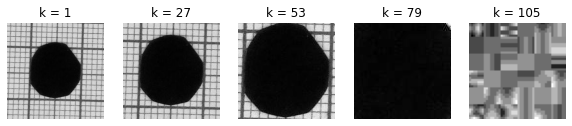

In [ ]:
N = 5
fig = plt.figure(figsize=(10, 2))
for i, k_i in enumerate(k[::len(k)//N+1]):
    fig.add_subplot(1, 5, i+1)
    vs.plot_image(img[k_i:-k_i, k_i:-k_i], cmap='gray')
    plt.title(f'k = {k_i}')

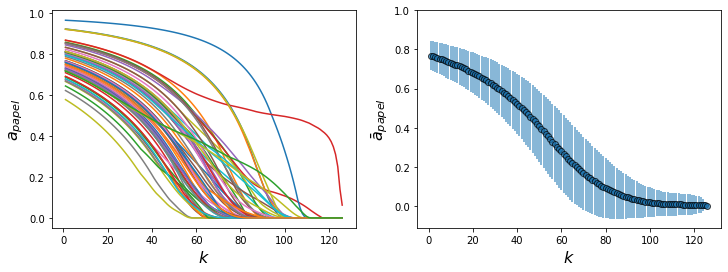

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k, a_papel)
ax1.set_xlabel(r'$k$', fontsize=16)
ax1.set_ylabel(r'$a_{papel}$', fontsize=16)
ax1.set_yticks(ax1.get_yticks()[1:-1])

ax2.errorbar(k, a_papel.mean(axis=1), a_papel.std(axis=1), fmt='-o', markeredgecolor='k', alpha=0.7)
ax2.set_xlabel(r'$k$', fontsize=16)
ax2.set_ylabel(r'$\bar{a}_{papel}$', fontsize=16)
ax2.set_yticks(ax1.get_yticks())

plt.show()

In [ ]:
%%time
scale_k = np.stack([[find_scale(image[k_i:-k_i, k_i:-k_i], sigma=2)[0] for image in images] for k_i in k])
scale_k.shape

CPU times: user 1min 33s, sys: 275 ms, total: 1min 33s
Wall time: 1min 34s


(126, 63)

In [ ]:
abs_error = np.abs(scale_true[np.newaxis] - scale_k)
rel_error = abs_error/scale_true[np.newaxis] * 100
rel_error.shape

(126, 63)

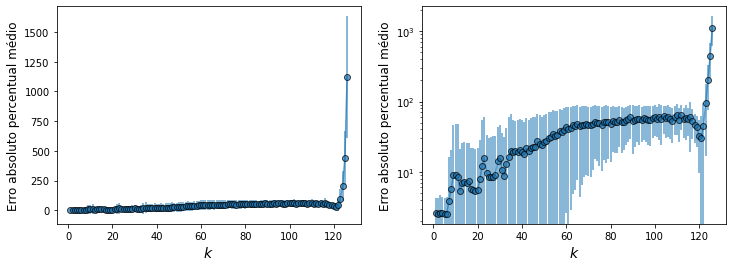

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.errorbar(k, rel_error.mean(axis=1), rel_error.std(axis=1), fmt='-o', alpha=0.7, markeredgecolor='k')
ax2.errorbar(k, rel_error.mean(axis=1), rel_error.std(axis=1), fmt='-o', alpha=0.7, markeredgecolor='k')
ax2.semilogy()

for ax in (ax1, ax2):
    ax.set_xlabel(f'$k$', fontsize=14)
    ax.set_ylabel('Erro absoluto percentual médio', fontsize=12)
plt.show()

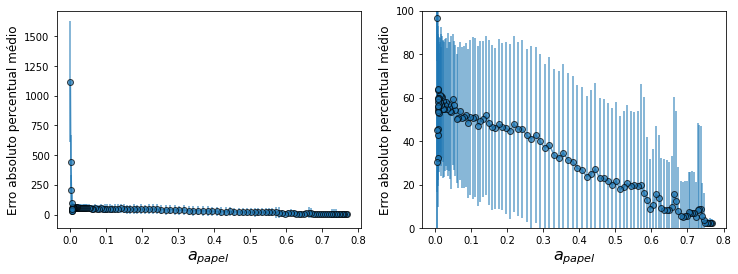

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.errorbar(a_papel.mean(axis=1), rel_error.mean(axis=1), rel_error.std(axis=1), fmt='-o', alpha=0.7, markeredgecolor='k')
ax2.errorbar(a_papel.mean(axis=1), rel_error.mean(axis=1), rel_error.std(axis=1), fmt='-o', alpha=0.7, markeredgecolor='k')
ax2.set_ylim(0, 100)

for ax in (ax1, ax2):
    ax.set_xlabel('$a_{papel}$', fontsize=16)
    ax.set_ylabel('Erro absoluto percentual médio', fontsize=12)
plt.show()